In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import glob
import librosa
import numpy as np

from torchsummary import summary

In [2]:
class AudioDataset(Dataset):
    def __init__(self, path, transform=None, sample_rate=16000):
        self.path = path
        self.data_list = glob.glob(self.path + '/*.wav')
        
        self.transform = transform
        self.sr = sample_rate
        self.frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
        self.frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data_path = self.data_list[idx]
        data = self.normalize(self.Mel_S(data_path))
        data = np.expand_dims(data, axis=0)
        
        if self.transform is not None:
            data = self.transform(data)
        
        return data # (1, 40, 80)
    
    def Mel_S(self, wav_file):
        y, sr = librosa.load(wav_file, sr=self.sr)
    
        input_nfft = int(round(sr*self.frame_length))
        input_stride = int(round(sr*self.frame_stride))

        s = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
#         print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
        
        return s
    
    def normalize(self, s):
        s = (s - s.mean()) / s.std() # standardization
        s = (s - s.min()) / (s.max() - s.min()) # min max normalization
        
        return s

In [3]:
class VAE(nn.Module):
    def __init__(self, input_channel=1, h_dim=128*5*10, z_dim=512):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 5, 10)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + std*eps # return z sample
    
    def bottleneck(self, h):
        mu, log_var = self.fc1(h), self.fc2(h)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var
    
    def encode(self, x):
        h = self.encoder(x)
        z, mu, log_var = self.bottleneck(h)
        return z, mu, log_var
    
    def decode(self, z):
        z = self.fc3(z)
        return self.decoder(z)
    
    def forward(self, x):
        z, mu, log_var = self.encode(x)
        recon = self.decode(z)
        return recon, mu, log_var

model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [4]:
model.load_state_dict(torch.load('model/vae_mel_200.pt'))

<All keys matched successfully>

In [5]:
summary(model, (1, 40, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 80]             320
              ReLU-2           [-1, 32, 40, 80]               0
         MaxPool2d-3           [-1, 32, 20, 40]               0
            Conv2d-4           [-1, 64, 20, 40]          18,496
              ReLU-5           [-1, 64, 20, 40]               0
         MaxPool2d-6           [-1, 64, 10, 20]               0
            Conv2d-7          [-1, 128, 10, 20]          73,856
              ReLU-8          [-1, 128, 10, 20]               0
         MaxPool2d-9           [-1, 128, 5, 10]               0
          Flatten-10                 [-1, 6400]               0
           Linear-11                  [-1, 512]       3,277,312
           Linear-12                  [-1, 512]       3,277,312
           Linear-13                 [-1, 6400]       3,283,200
        Unflatten-14           [-1, 128

In [6]:
normal_dataset = AudioDataset(path='data/원천데이터/normal_1s')
abnormal_dataset = AudioDataset(path='data/원천데이터/abnormal_1s')

normal_loader = DataLoader(dataset=normal_dataset, batch_size=1, shuffle=False)
abnormal_loader = DataLoader(dataset=abnormal_dataset, batch_size=1, shuffle=False)

In [17]:
def loss_function(recon_x, x, mu, log_var):
#     KLD = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    return BCE

In [18]:
normal_loss = []
model.eval()
for idx, normal_data in enumerate(normal_loader):
    normal_data = normal_data.cuda()
    recon, mu, log_var = model(normal_data)
    loss = loss_function(recon, normal_data, mu, log_var)
    normal_loss.append(loss.item())
    if (idx+1) % 100 == 0:
        print(f'--{((idx+1) / normal_loader.__len__()) * 100 :0.2f}%', end='')
print("--100% \n done")

--2.96%--5.93%--8.89%--11.85%--14.81%--17.78%--20.74%--23.70%--26.67%--29.63%--32.59%--35.56%--38.52%--41.48%--44.44%--47.41%--50.37%--53.33%--56.30%--59.26%--62.22%--65.19%--68.15%--71.11%--74.07%--77.04%--80.00%--82.96%--85.93%--88.89%--91.85%--94.81%--97.78%--100% 
 done


In [19]:
abnormal_loss = []
model.eval()
for idx, abnormal_data in enumerate(abnormal_loader):
    abnormal_data = abnormal_data.cuda()
    recon, mu, log_var = model(abnormal_data)
    loss = loss_function(recon, abnormal_data, mu, log_var)
    abnormal_loss.append(loss.item())
    if (idx+1) % 100 == 0:
        print(f'--{((idx+1) / abnormal_loader.__len__()) * 100 :0.2f}%', end='')
print("--100% \n done")

/tmp/ipykernel_246858/2597958812.py:36: RuntimeWarning: invalid value encountered in true_divide
  s = (s - s.mean()) / s.std() # standardization


--3.46%--6.91%--10.37%--13.82%--17.28%--20.73%--24.19%--27.64%--31.10%--34.55%--38.01%--41.47%--44.92%--48.38%--51.83%--55.29%--58.74%--62.20%--65.65%--69.11%--72.56%--76.02%--79.47%--82.93%--86.39%--89.84%--93.30%--96.75%--100% 
 done


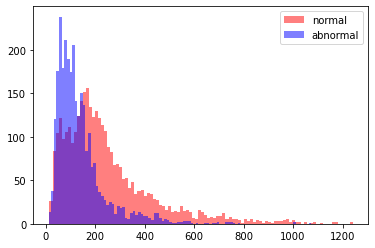

In [20]:
import matplotlib.pyplot as plt


plt.hist(normal_loss, color='r', alpha=0.5, bins=100, label='normal')
plt.hist(abnormal_loss, color='b', alpha=0.5, bins=100, label='abnormal')
plt.legend()

plt.show()